<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/cellAtlas_Generation_KNN_NCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Jul  7 20:27:09 UTC 2020


In [1]:
#Read in filtered starved data
!wget --quiet https://caltech.box.com/shared/static/4jr6eqg6qnnrj2c8orlf7fwo7scyj6s1
#Original clustering 
!wget --quiet https://caltech.box.com/shared/static/ts2i8pid7uky28kke4duyl8jwugx8z4h

#Read in filtered stimulation data 
!wget --quiet https://caltech.box.com/shared/static/hd36giuxz3zd933fh4bca3iqnykncro8

In [2]:
#Unfiltered, raw starvation counts
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

#Unfiltered, raw stimulation counts
!wget --quiet https://caltech.box.com/shared/static/cy5n9b6rdyk7v4uhvgvpkgotmchlts45

In [ ]:
#Save merged datasets
!wget --quiet https://caltech.box.com/shared/static/jf24fsdq7ojrbwxwf3mc7pqecnrjhpem

#Data only contained Fed and SW control
!wget --quiet https://caltech.box.com/shared/static/tq6f5fqcmhw9h6kphzk8bvt5qx8xew90

In [3]:
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

     |████████████████████████████████| 122kB 2.9MB/s 
     |████████████████████████████████| 7.2MB 2.2MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 3.2MB 16.6MB/s 


###**Import packages**

In [4]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

###**Map Starvation Labels and to Stimulation Cells**

Read in data

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score'
    var: 'n_counts'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 13673 × 2657
    obs: 'n_counts', 'n_countslog', 'louvain', 'orgID', 'fed', 'starved', 'fed_ord', 'starved_ord', 'new_fed', 'fed_neighbor_score'
    var: 'n_counts', 'n_cells'
    uns: 'fed_ord_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'new_fed_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'starved_ord_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 19054 × 10260
    obs: 'batch', 'n_counts', 'n_countslog', 'leiden', 'condition', 'orgID

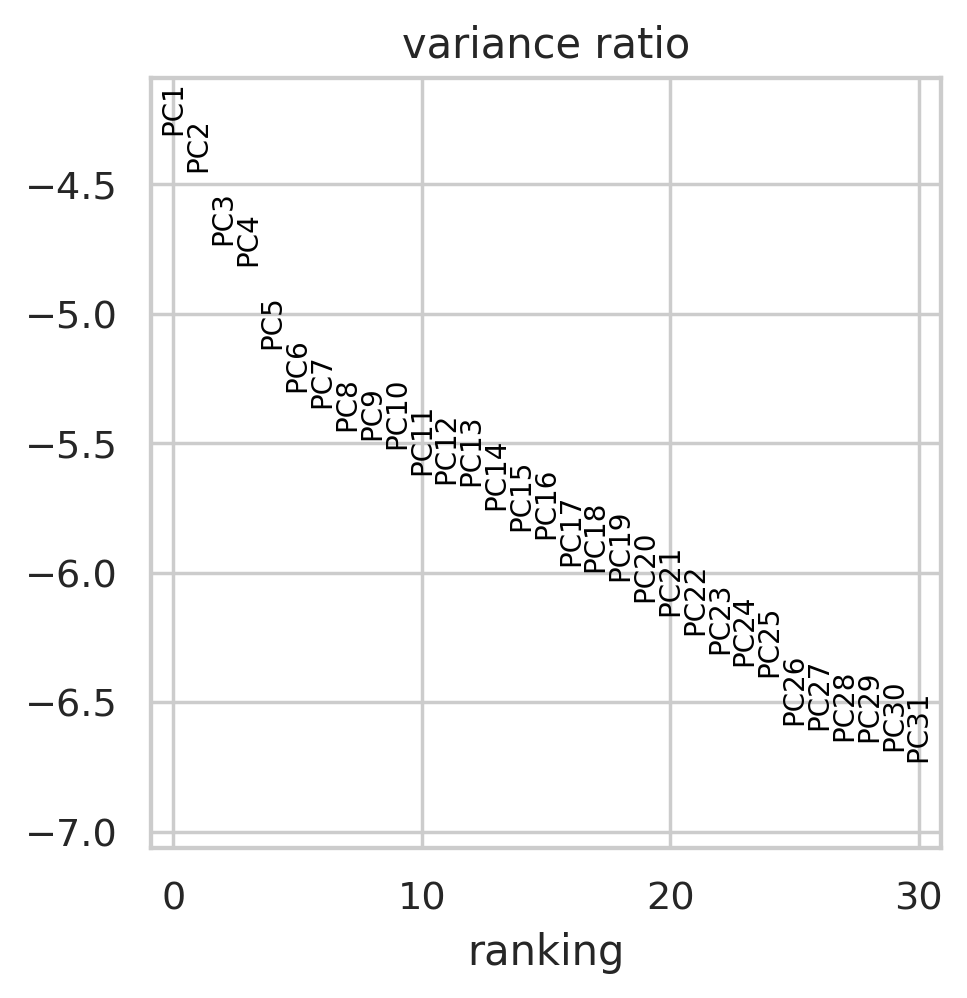

AnnData object with n_obs × n_vars = 32727 × 6756
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'condition'
    var: 'n_counts-0', 'n_counts-1'
    uns: 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [8]:
#bus_fs_combo data (filtered bus data), bus_combo_noZero (filtered stim data)

#bus_fs_combo
bus_fs_combo = anndata.read("4jr6eqg6qnnrj2c8orlf7fwo7scyj6s1")

orig = anndata.read("ts2i8pid7uky28kke4duyl8jwugx8z4h")

print(bus_fs_combo)
print(orig)
#bus_combo_noZero
bus_combo_noZero = anndata.read("hd36giuxz3zd933fh4bca3iqnykncro8")
print(bus_combo_noZero)


Predict labels for stimulation data


In [ ]:
#Make X_pca with merged, use top 30 PC's
def getPredLabels(overlap_fs,overlap_combo, orig):
    
    numFS = len(overlap_fs.obs_names)
    X_train = overlap_combo.obsm['X_pca'][0:numFS,0:30]

    #X_pca at stim rows = X_test
    X_test = overlap_combo.obsm['X_pca'][numFS:,0:30]

    #y_train is f/s louvain labels
    names = [x.replace('_fs','') for x in overlap_fs.obs_names]
    orig = orig[names,]
    y_train = orig.obs['louvain']

    #Fit and predict
    classifier = KNeighborsClassifier(n_neighbors=15)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    labels = list(y_train)+list(y_pred)
    
    print(len(labels),' labels created')
    
    return labels


In [ ]:
#Predict cluster labels for stim

def applyNCAEmbed(overlap_combo,overlap_fs,labels):
    
    overlap_combo.obs['knn_clus'] = pd.Categorical(labels)
    
    nca = NeighborhoodComponentsAnalysis(n_components=30)
    knn = KNeighborsClassifier() # what is default # neighbors?
    nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
    X_nca = nca.fit_transform(overlap_combo.X,labels)
    overlap_combo.obsm['X_nca'] = X_nca
    
    print('Finished NCA embedding')
    
    X_embedded = TSNE(n_components=2,perplexity = 50).fit_transform(X_nca)
    overlap_combo.obsm['X_tsne'] = X_embedded
    
    print('Finished tSNE embedding')

Generate reduced, linear embedding of merged data with new labels

In [ ]:
def plotEmbed(overlap_combo, overlap_fs,overlap_stim):
    
    origin_label = list(np.repeat('FS',len(overlap_fs.obs_names)))+list(np.repeat('Stim',len(overlap_stim.obs_names)))
    overlap_combo.obs['cell_origin'] =  pd.Categorical(origin_label)
    overlap_combo

    sc.pl.tsne(overlap_combo,color=['knn_clus'],color_map='viridis',legend_loc='on data')
    sc.pl.tsne(overlap_combo,color=['XLOC_019434','cell_origin'],color_map='viridis')


In [ ]:
#Get intersection of var names between the two
overlap = list(set(bus_combo_noZero.var_names).intersection(bus_fs_combo.var_names))

overlap_fs = bus_fs_combo[:,overlap]

overlap_stim = bus_combo_noZero[:,overlap]


#Merge datasets
overlap_fs.obs_names = [i+'_fs' for i in overlap_fs.obs_names]
overlap_stim.obs_names = [i+'_ieg' for i in overlap_stim.obs_names]

overlap_combo = overlap_fs.concatenate(overlap_stim,join='outer', index_unique=None)

sc.pp.scale(overlap_combo, max_value=10)

#Do PCA on merged dataset + plot variance explained
sc.tl.pca(overlap_combo, n_comps=60)
sc.pl.pca_variance_ratio(overlap_combo, log=True)

overlap_combo

labels = getPredLabels(overlap_fs,overlap_combo, orig)

applyNCAEmbed(overlap_combo,overlap_fs,labels)
plotEmbed(overlap_combo, overlap_fs,overlap_stim)


In [ ]:
#Discrete and continuous mapping with PAGA (vs tSNE)
sc.pp.neighbors(overlap_combo,n_pcs=30, n_neighbors=60, use_rep='X_nca') #n_pcs=30
sc.tl.paga(overlap_combo, groups='knn_clus')

sc.pl.paga(overlap_combo,color=['knn_clus'],threshold=0.1,max_edge_width=1)

In [ ]:
sc.tl.draw_graph(overlap_combo, init_pos='paga', layout='fa', maxiter=500)
sc.pl.draw_graph(overlap_combo,color=['knn_clus','XLOC_030068','XLOC_012650'],
                 title=['Cluster','Dkk-3 XLOC_030068','Old Neuron Marker - XLOC_012650'],legend_loc='on data')


In [ ]:
# #Scramble labels
# import random

# #Get intersection of var names between the two
# overlap = list(set(bus_combo_noZero.var_names).intersection(bus_fs_combo.var_names))

# overlap_fs = bus_fs_combo[:,overlap]

# overlap_stim = bus_combo_noZero[:,overlap]


# #Merge datasets
# overlap_fs.obs_names = [i+'_fs' for i in overlap_fs.obs_names]
# overlap_stim.obs_names = [i+'_ieg' for i in overlap_stim.obs_names]

# overlap_combo = overlap_fs.concatenate(overlap_stim,join='outer', index_unique=None)

# sc.pp.scale(overlap_combo, max_value=10)

# #Do PCA on merged dataset + plot variance explained
# sc.tl.pca(overlap_combo, n_comps=60)
# sc.pl.pca_variance_ratio(overlap_combo, log=True)

# overlap_combo

# labels = getPredLabels(overlap_fs,overlap_combo, orig)

# #Shuffle labels
# numFS = len(overlap_fs.obs_names)
# stimLabels = list(labels[numFS:])

# random.shuffle(stimLabels)
# newLabels = labels[0:numFS]+stimLabels

In [ ]:
# applyNCAEmbed(overlap_combo,overlap_fs,newLabels)
# plotEmbed(overlap_combo, overlap_fs,overlap_stim)

In [ ]:
#Make overlap_combo just fed and SW

#Get intersection of var names between the two
overlap = list(set(bus_combo_noZero.var_names).intersection(bus_fs_combo.var_names))

overlap_fs_fed = bus_fs_combo[bus_fs_combo.obs['fed'] == True]
overlap_fs_fed = overlap_fs_fed[:,overlap]

overlap_stim_sw = bus_combo_noZero[bus_combo_noZero.obs['condition'] == 'SW']
overlap_stim_sw = overlap_stim_sw[:,overlap]


#Merge datasets
overlap_fs_fed.obs_names = [i+'_fs' for i in overlap_fs_fed.obs_names]
overlap_stim_sw.obs_names = [i+'_ieg' for i in overlap_stim_sw.obs_names]

overlap_combo_fed_sw = overlap_fs_fed.concatenate(overlap_stim_sw,join='outer', index_unique=None)

sc.pp.scale(overlap_combo_fed_sw, max_value=10)

#Do PCA on merged dataset + plot variance explained
sc.tl.pca(overlap_combo_fed_sw, n_comps=60)
sc.pl.pca_variance_ratio(overlap_combo_fed_sw, log=True)

overlap_combo_fed_sw

labels = getPredLabels(overlap_fs_fed,overlap_combo_fed_sw, oj2_metadata)
applyNCAEmbed(overlap_combo_fed_sw,overlap_fs_fed,oj2_metadata,labels)
plotEmbed(overlap_combo_fed_sw, overlap_fs_fed,overlap_stim_sw)

In [ ]:
#Discrete and continuous plotting with PAGA (vs tSNE)
sc.pp.neighbors(overlap_combo_fed_sw,n_pcs=30, n_neighbors=500, use_rep='X_nca') #n_pcs=30
sc.tl.paga(overlap_combo_fed_sw, groups='knn_clus')

sc.pl.paga(overlap_combo_fed_sw,color=['knn_clus'],threshold=0.1,max_edge_width=1)

sc.tl.draw_graph(overlap_combo_fed_sw, init_pos='paga', layout='fa', maxiter=500)

sc.pl.draw_graph(overlap_combo_fed_sw,color=['knn_clus','XLOC_030068'],legend_loc='on data')

###**Visualize marker genes and use SAVED data**

In [ ]:
#Read in saved, merged data sets
overlap_combo = anndata.read("jf24fsdq7ojrbwxwf3mc7pqecnrjhpem")

overlap_combo_fed_sw = anndata.read("tq6f5fqcmhw9h6kphzk8bvt5qx8xew90")

#Rank and extract marker genes for all clusters
#Keep top 30 genes
sc.tl.rank_genes_groups(overlap_combo, 'knn_clus', n_genes=30,method='t-test')

#Plot top marker gene for each cluster

markers = []
for i in np.unique(overlap_combo.obs['knn_clus']):
     markers += [overlap_combo.uns['rank_genes_groups']['names'][i][0]]

sc.pl.umap(overlap_combo,color=markers,color_map = 'viridis')

Visualize other genes with unfiltered gene list

In [ ]:
#Raw counts, no clustering h5ad, from Kallisto bus
jelly4stim = anndata.read("cy5n9b6rdyk7v4uhvgvpkgotmchlts45")

#Remove Cluster '0' cells (low umi counts and gene expression)
jelly4stim = jelly4stim[bus_combo_noZero.obs_names,]


#Add _ieg to cell names
jelly4stim.obs_names = [i+'_ieg' for i in jelly4stim.obs_names]


stim_data = AnnDatasetFromAnnData(ad = jelly4stim)

#Filter zero count genes
stim_data.filter_genes_by_count(per_batch=True)
print(stim_data)



#Read in Fed/Starved data, raw counts, no clustering
oj2 = anndata.read("3l60szs0e9hgaax4q9dbuehgoo092xww")

#Add _fs to cell names
oj2.obs_names = [i+'_fs' for i in oj2.obs_names]


fs_data = AnnDatasetFromAnnData(ad = oj2)

#Filter zero count genes
fs_data.filter_genes_by_count(per_batch=True)
print(fs_data)


#Concatenate data (with all nonzero genes)
combo = jelly4stim.concatenate(oj2,join='outer', index_unique=None)

In [ ]:
#Save obs to combo data, which contains all nonzero ('unfiltered') genes for downstream analysis/visualizations
combo = combo[overlap_combo.obs_names,]
combo.raw = sc.pp.log1p(combo, copy=True)
sc.pp.normalize_per_cell(combo, counts_per_cell_after=1e4)
sc.pp.scale(combo, max_value=10)

#Transfer info from embedded version
combo.obs['knn_clus'] = overlap_combo.obs['knn_clus']
combo.obs['cell_origin'] = overlap_combo.obs['cell_origin']
combo.obsm['X_tsne'] = overlap_combo.obsm['X_tsne']

In [ ]:
#Can plot genes with combo now

###**Determine which clusters to sub-cluster**

In [ ]:
#Plot distances between centroid of stim-starved and fed-starved for each cluster
def changeBool(fed):
    if fed == 'True':
        return 'fed'
    elif fed == 'False':
        return 'starved' 
    else:
        return 'stim'

def addConds(overlap_combo):
    fs_conds = [changeBool(i) for i in overlap_combo.obs['fed']]
    overlap_combo.obs['centroid_conds'] = pd.Categorical(fs_conds)

    overlap_combo.obs['centroid_conds']

In [ ]:
def getCentroidDists(overlap_combo):
    fedStarv = []
    fsStim = []

    cluster = []

    #Initialize output matrix
    addConds(overlap_combo)
    clusters = np.unique(overlap_combo.obs['knn_clus'])
    centroid_dist = pd.DataFrame(columns =['fedStarv','fsStim','cluster','clus_color']) 

    for c in clusters:
        #Get cells in cluster and their conditions
        sub_data = overlap_combo[overlap_combo.obs['knn_clus'] == c]
        centroid_conds = sub_data.obs['centroid_conds'] 

        #Get 2D tsne embedding
        pca_embed = sub_data.obsm['X_pca'] #PCA

        #Get location of condition cells
        stim_pos = list(centroid_conds == 'stim')
        allFS_pos = list(centroid_conds != 'stim')
        fed_pos = list(centroid_conds == 'fed')
        starved_pos = list(centroid_conds == 'starved')

        #Get column means for x,y coords
        meanFed = pca_embed[fed_pos,].mean(axis=0)

        meanStarv = pca_embed[starved_pos,].mean(axis=0)

        meanStim = pca_embed[stim_pos,].mean(axis=0)

        meanFS = pca_embed[allFS_pos,].mean(axis=0)


        cluster += [c]

        #Dist between fed and starved
        fs_dist = np.linalg.norm(meanFed - meanStarv)

        #Dist between (all) starved experiment and stim

        starvStim_dist = np.linalg.norm(meanFS - meanStim)

        fedStarv += [fs_dist]
        fsStim += [starvStim_dist]

    centroid_dist['fedStarv'] = fedStarv
    centroid_dist['fsStim'] = fsStim

    centroid_dist['cluster'] = cluster

    return centroid_dist

In [ ]:
allCells_Dists = getCentroidDists(overlap_combo)
controlCells_Dists = getCentroidDists(overlap_combo_fed_sw)

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(x='cluster', y='fedStarv', data=allCells_Dists,color='red',label='fed-starved')
plt.scatter(x='cluster', y='fsStim', data=allCells_Dists,color='blue',label='starved-stim')
plt.scatter(x='cluster', y='fsStim', data=controlCells_Dists,color='black',label='fed-sw control')
plt.legend()
plt.xticks(np.arange(min(allCells_Dists['cluster']), max(allCells_Dists['cluster'])+1, 1))
plt.show()

Do sub-clustering


In [ ]:
clus21 = overlap_combo[overlap_combo.obs['knn_clus'].isin([21])]
sc.pp.scale(clus21, max_value=10)

sc.tl.pca(clus21, n_comps=60)
#sc.pl.pca_variance_ratio(bus_combo, log=True)
#sc.tl.tsne(bus_fs_combo, n_pcs=30)

sc.pp.neighbors(clus21,n_neighbors=40, n_pcs=30) #n_neighbors=5, n_pcs=15
sc.tl.leiden(clus21,resolution=0.5)
sc.tl.umap(clus21)
sc.pl.umap(clus21, color=['leiden','cell_origin'])


In [ ]:
#Keep top 30 genes
sc.tl.rank_genes_groups(clus21, 'leiden', n_genes=30,method='t-test')

#Plot top marker gene for each cluster

markers = []
for i in np.unique(clus21.obs['leiden']):
     markers += list(clus21.uns['rank_genes_groups']['names'][str(i)][0:2])

sc.pl.umap(clus21,color=markers,color_map = 'viridis')

In [ ]:
#Optimize for pseudotime and cell type labels in embedding